In [1]:
#import libraries to build the model

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np

import keras

from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from sklearn.mixture import GaussianMixture
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
normal_x = x_train[y_train == 1]
x_test = x_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [3]:
#results can be from 0 to 9
num_classes = len(np.unique(y_train))
#determine batch size
batch_size = 250
#determine epoch
epochs = 10


In [4]:
#build a GMM with number of unşque values of y_train dataset
gmm = GaussianMixture(n_components=num_classes)

In [5]:
def reshape_x(x):
    new_x = np.empty((len(x), 56, 56))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (56, 56))

    new_x = np.expand_dims(new_x, axis=-1)
    new_x = np.repeat(new_x, 3, axis=-1)
    return new_x

In [6]:
#transform 2D 56x56 matrix to 3D (56x56x1) matrix

#x_train_normal = reshape_x(normal_x)
#x_test_normal = reshape_x(x_test)

In [7]:
#transform 2D 28x28 matrix to 3D (28x28x1) matrix
x_normal = normal_x.reshape(normal_x.shape[0], 28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_normal = np.expand_dims(x_normal, axis=-1)
x_normal = np.repeat(x_normal, 3, axis=-1)

x_normal = x_normal.astype('float32')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#inputs have to be between [0, 1]
x_normal /= 255
x_train /= 255
x_test /= 255

print('x_normal shape:', x_normal.shape)
print('x_train shape:', x_train.shape)

print(x_normal.shape[0], 'normal samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_normal shape: (6742, 28, 28, 1, 3)
x_train shape: (60000, 28, 28, 1)
6742 normal samples
60000 train samples
2115 test samples


In [8]:
x_normal.shape

(6742, 28, 28, 1, 3)

In [9]:
# convert labels to binary form
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#create neural networks structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(32, (3, 3) #32 is number of filters and (3, 3) is the size of the filter.
	, input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3))) # apply 64 filters sized of (3x3) on 2nd convolution layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer. 1 hidden layer consisting of 512 nodes
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
x_normal.shape

(6742, 28, 28, 1, 3)

In [12]:
#Train the model with small size instances. Thus, you can create a model with a single CPU in a short time.
gen = ImageDataGenerator()

train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [13]:
x_test.shape , y_test.shape

((2115, 28, 28, 1), (2115, 10))

In [14]:
model.compile(loss='categorical_crossentropy'
	, optimizer=keras.optimizers.Adam()
	, metrics=['accuracy']
)

model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs, 
	validation_data=(x_test, y_test) #validate on all test set
)
model.save("model.hdf5")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
240/250 [===========================>..] - 50s 207ms/step - loss: 0.2397 - accuracy: 0.9322 - val_loss: 0.0261 - val_accuracy: 0.9920


In [15]:
x_normal.shape

(6742, 28, 28, 1, 3)

In [17]:
#CONV2 model to extract features from training data
model = load_model("model.hdf5")

features = model.predict(x_test)
#gmm.fit(features)

In [18]:
gmm.fit(features)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [24]:
#VGG model to extract features from testing data
OKscore = gmm.score_samples(features)
thred = OKscore.mean() - 3 * OKscore.std()

test_features = model.predict(x_test)
score = gmm.score_samples(test_features)
"""
print('normal accuracy: %.2f' % (len(score[(y_test == 1) & (score > thred)]) / 1135))
print('abnormal accuracy: %.2f' % (len(score[(y_test == 0) & (score < thred)]) / 1028))
"""

"\nprint('normal accuracy: %.2f' % (len(score[(y_test == 1) & (score > thred)]) / 1135))\nprint('abnormal accuracy: %.2f' % (len(score[(y_test == 0) & (score < thred)]) / 1028))\n"

In [25]:
score

array([56.11076581, 57.35056839, 56.08761736, ..., 56.02505523,
       29.12295714, 56.01251585])

In [26]:
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

Test loss: 56.11076580569636
Test accuracy: 5735.056839183461


In [27]:
score2 = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', 100*score2[1])

Test loss: 0.026122283190488815
Test accuracy: 99.1962194442749


In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('normal accuracy:', 100 - score[0])
print('abnormal accuracy:', 100*score[1])

normal accuracy: 99.97387771680951
abnormal accuracy: 99.1962194442749


predict:  8  actual:  1


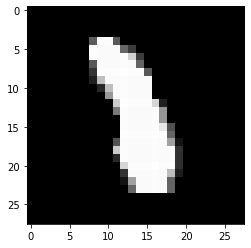

predict:  5  actual:  0


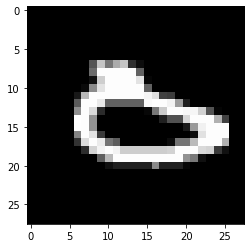

predict:  6  actual:  0


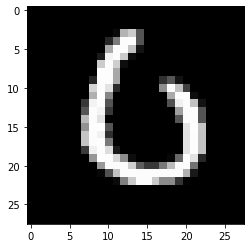

predict:  7  actual:  1


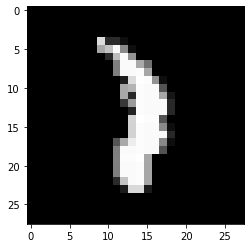

predict:  3  actual:  1


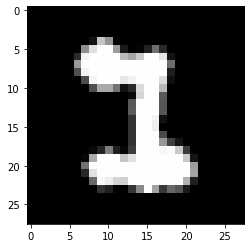

predict:  2  actual:  1


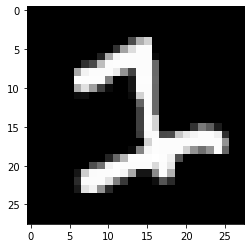

predict:  7  actual:  0


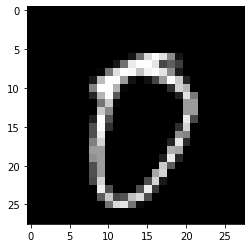

predict:  3  actual:  1


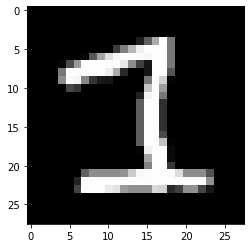

predict:  2  actual:  0


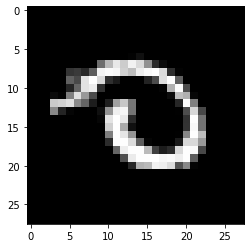

predict:  8  actual:  0


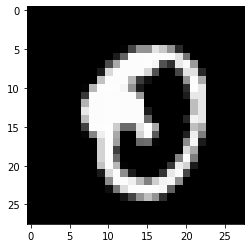

predict:  6  actual:  1


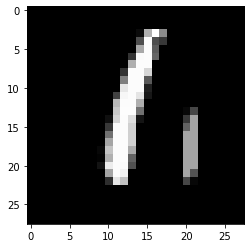

predict:  0  actual:  1


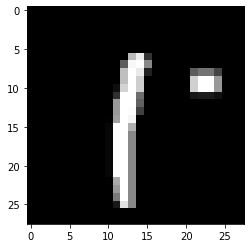

predict:  7  actual:  1


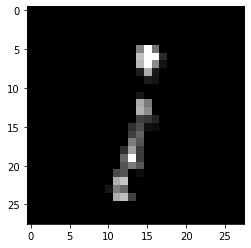

predict:  7  actual:  0


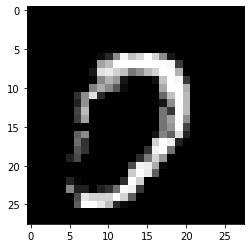

predict:  8  actual:  0


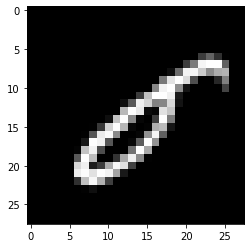

predict:  2  actual:  0


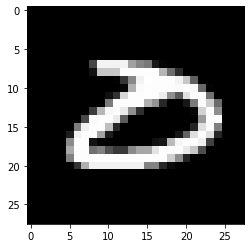

predict:  7  actual:  0


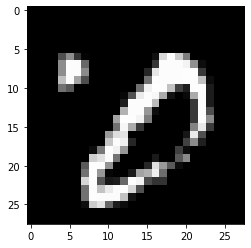

In [29]:
model = load_model("model.hdf5")

predictions = model.predict(x_test)

#display wrongly classified instances
index = 0
for i in predictions:
	if index < 10000:
		actual = np.argmax(y_test[index])
		pred = np.argmax(i)
		
		if actual != pred:
			print("predict: ",pred," actual: ",actual)
			picture = x_test[index]
			picture = picture.reshape([28, 28]);
			plt.gray()
			plt.imshow(picture)
			plt.show()
		
	index = index + 1